In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
# from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import state tomography modules
from qiskit_experiments.library import StateTomography
from osp_solutions.patch_ignis import rename_qcs_StateTomography_to_ignis
from osp_solutions.tomography import StateTomographyFitter
from qiskit.quantum_info import state_fidelity

In [ ]:
from osp_solutions.circuits_util import append_block_trotter_proposed, append_initial_state, append_block_trotter_aj, append_block_trotter_negishi
from osp_solutions.simulator_dm import make_dm_binary, hamiltonian_to_dm, DMExtended
from osp_solutions.hamiltonian import Hamiltonian, make_H_Heisenberg
from osp_solutions.backend_simulator import result_to_dms
from setting import *

In [6]:
dt = Parameter('t')
state_initial_dm = DMExtended(matrix=make_dm_binary(str_binary=state_initial_str, 
                                                    endian_binary="little_endian", 
                                                    endian_dm="big_endian")) ### make the density matrix for the initial state

H_Heisenberg = make_H_Heisenberg(num_qubits=num_qubits) ### create Heisenberg Hamiltonian in a dictionary format
matrix_Heisenberg = hamiltonian_to_dm(hamiltonian=H_Heisenberg) ### convert Heisenberg Hamiltonian to its matrix form

U_Heisenberg = DMExtended(sp.linalg.expm(-1.0j * matrix_Heisenberg * time_evolution)) ### prepare the unitary matrix of the Heisenberg Hamiltonian

state_target_dm = state_initial_dm.apply_unitary(U_Heisenberg) ### apply the unitary evolution to the density matrix
state_target_dm.is_valid()

trotter step list:  [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96]


True

In [7]:
fidelities = []
nums_cnots = []

print("trotter step list: ", num_steps_list)
for num_steps in num_steps_list:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()
    
    # Initialize quantum circuit for 3 qubits
    qc = QuantumCircuit(num_qubits)

    # Prepare initial state
    append_initial_state(qc=qc, 
                         state_initial_str=state_initial_str)
    append_block_trotter_proposed(qc=qc, 
                                  dt=dt,  ###!
                                  num_steps=num_steps, ###!
                                 )

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.assign_parameters({dt: time_evolution / num_steps})
    qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=3, basis_gates=["sx", "cx", "rz"])
    qc_t3.save_density_matrix()
    
    ### execute circuits
    result_raw = simulator_ideal.run(qc_t3,
                                        shots=0,
                                        ).result()
    dm_raw = result_to_dms(result=result_raw,
                        endian_dm="big")[0]

    fidelities.append(state_fidelity(dm_raw, state_target_dm))
    nums_cnots.append(qc_t3.count_ops().get("cx"))
    
    t2 = time.perf_counter()
    print('raw state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fidelities), np.std(fidelities)))
    print("number of CNOT gates:", qc_t3.count_ops().get("cx"))
    print("time:", t2 - t1)
    print()

trotter steps:  4
raw state tomography fidelity = 0.0150 ± 0.0000
number of CNOT gates: None
time: 0.4095859171357006

trotter steps:  8
raw state tomography fidelity = 0.0143 ± 0.0007
number of CNOT gates: 112
time: 0.5497568328864872

trotter steps:  12
raw state tomography fidelity = 0.0139 ± 0.0008
number of CNOT gates: 168
time: 0.5416717911139131

trotter steps:  16
raw state tomography fidelity = 0.0211 ± 0.0126
number of CNOT gates: 224
time: 0.5929474590811878

trotter steps:  20
raw state tomography fidelity = 0.0611 ± 0.0806
number of CNOT gates: 280
time: 0.6346956249326468

trotter steps:  24
raw state tomography fidelity = 0.1166 ± 0.1444
number of CNOT gates: 336
time: 0.6835957090370357

trotter steps:  28
raw state tomography fidelity = 0.1753 ± 0.1963
number of CNOT gates: 392
time: 0.7810981250368059

trotter steps:  32
raw state tomography fidelity = 0.2314 ± 0.2361
number of CNOT gates: 448
time: 0.7540733339264989

trotter steps:  36
raw state tomography fidelity 

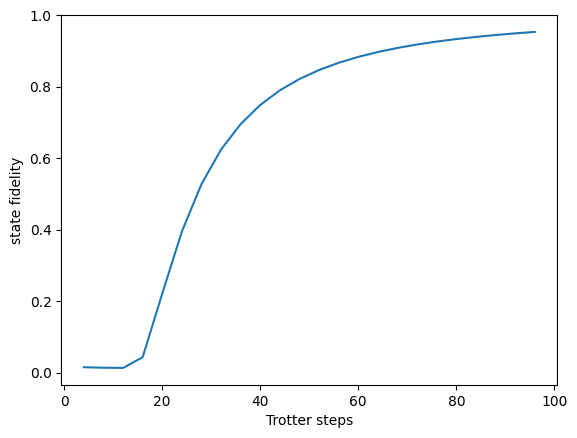

In [8]:
plt.plot(num_steps_list, fidelities)
plt.xlabel("Trotter steps")
plt.ylabel("state fidelity")
plt.show()

In [9]:
with open("run_trotter_"+str(num_qubits)+"-qubit_proposed.pkl", "wb") as f:
    pickle.dump({"num_steps_list": num_steps_list, "fidelities": fidelities, "nums_cnots": nums_cnots}, f)

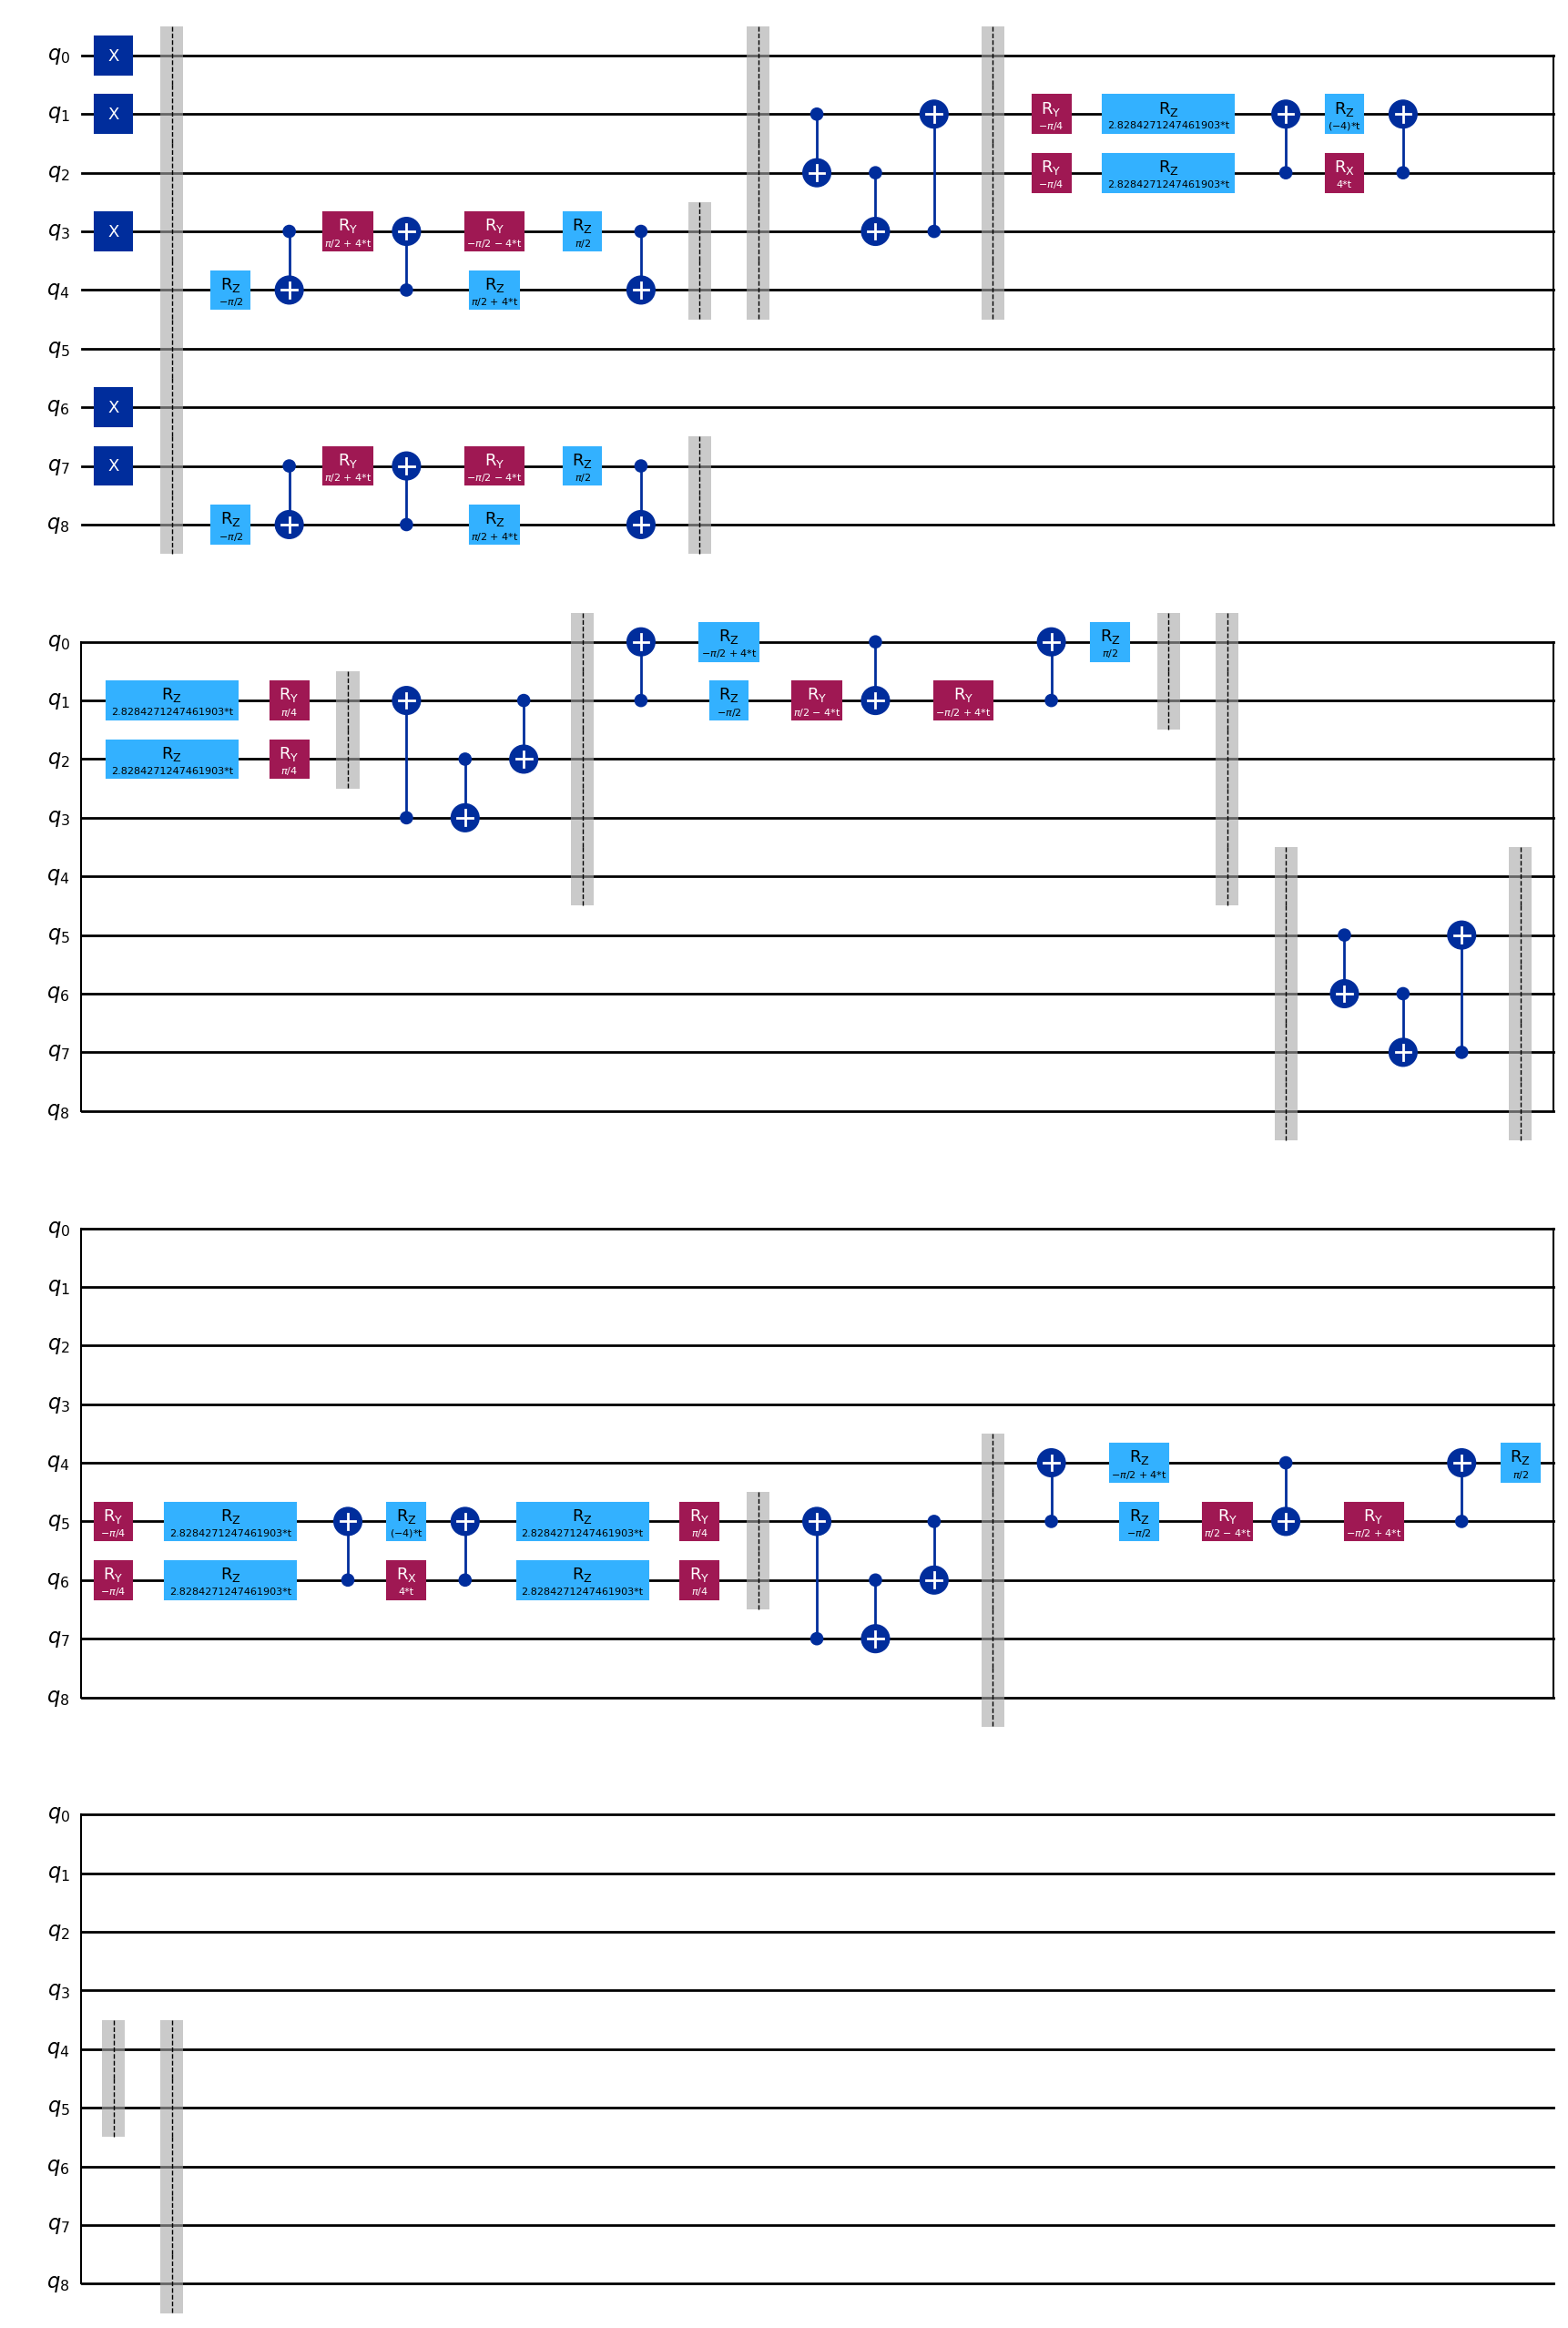

In [ ]:
qc = QuantumCircuit(num_qubits)

# Prepare initial state
append_initial_state(qc=qc, 
                     state_initial_str=state_initial_str,
                     add_barrier=True)
append_block_trotter_proposed(qc=qc, 
                              dt=dt, 
                              num_steps=2,
                              to_instruction=False,
                              add_barrier=True)

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
# qc = qc.assign_parameters({dt: time_evolution / num_steps})
# qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=3, basis_gates=["sx", "cx", "rz"])
# qc_t3 = transpile(qc, optimization_level=3, basis_gates=["sx", "cx", "rz"])
# qc_t3.save_density_matrix()s
qc.draw("mpl")

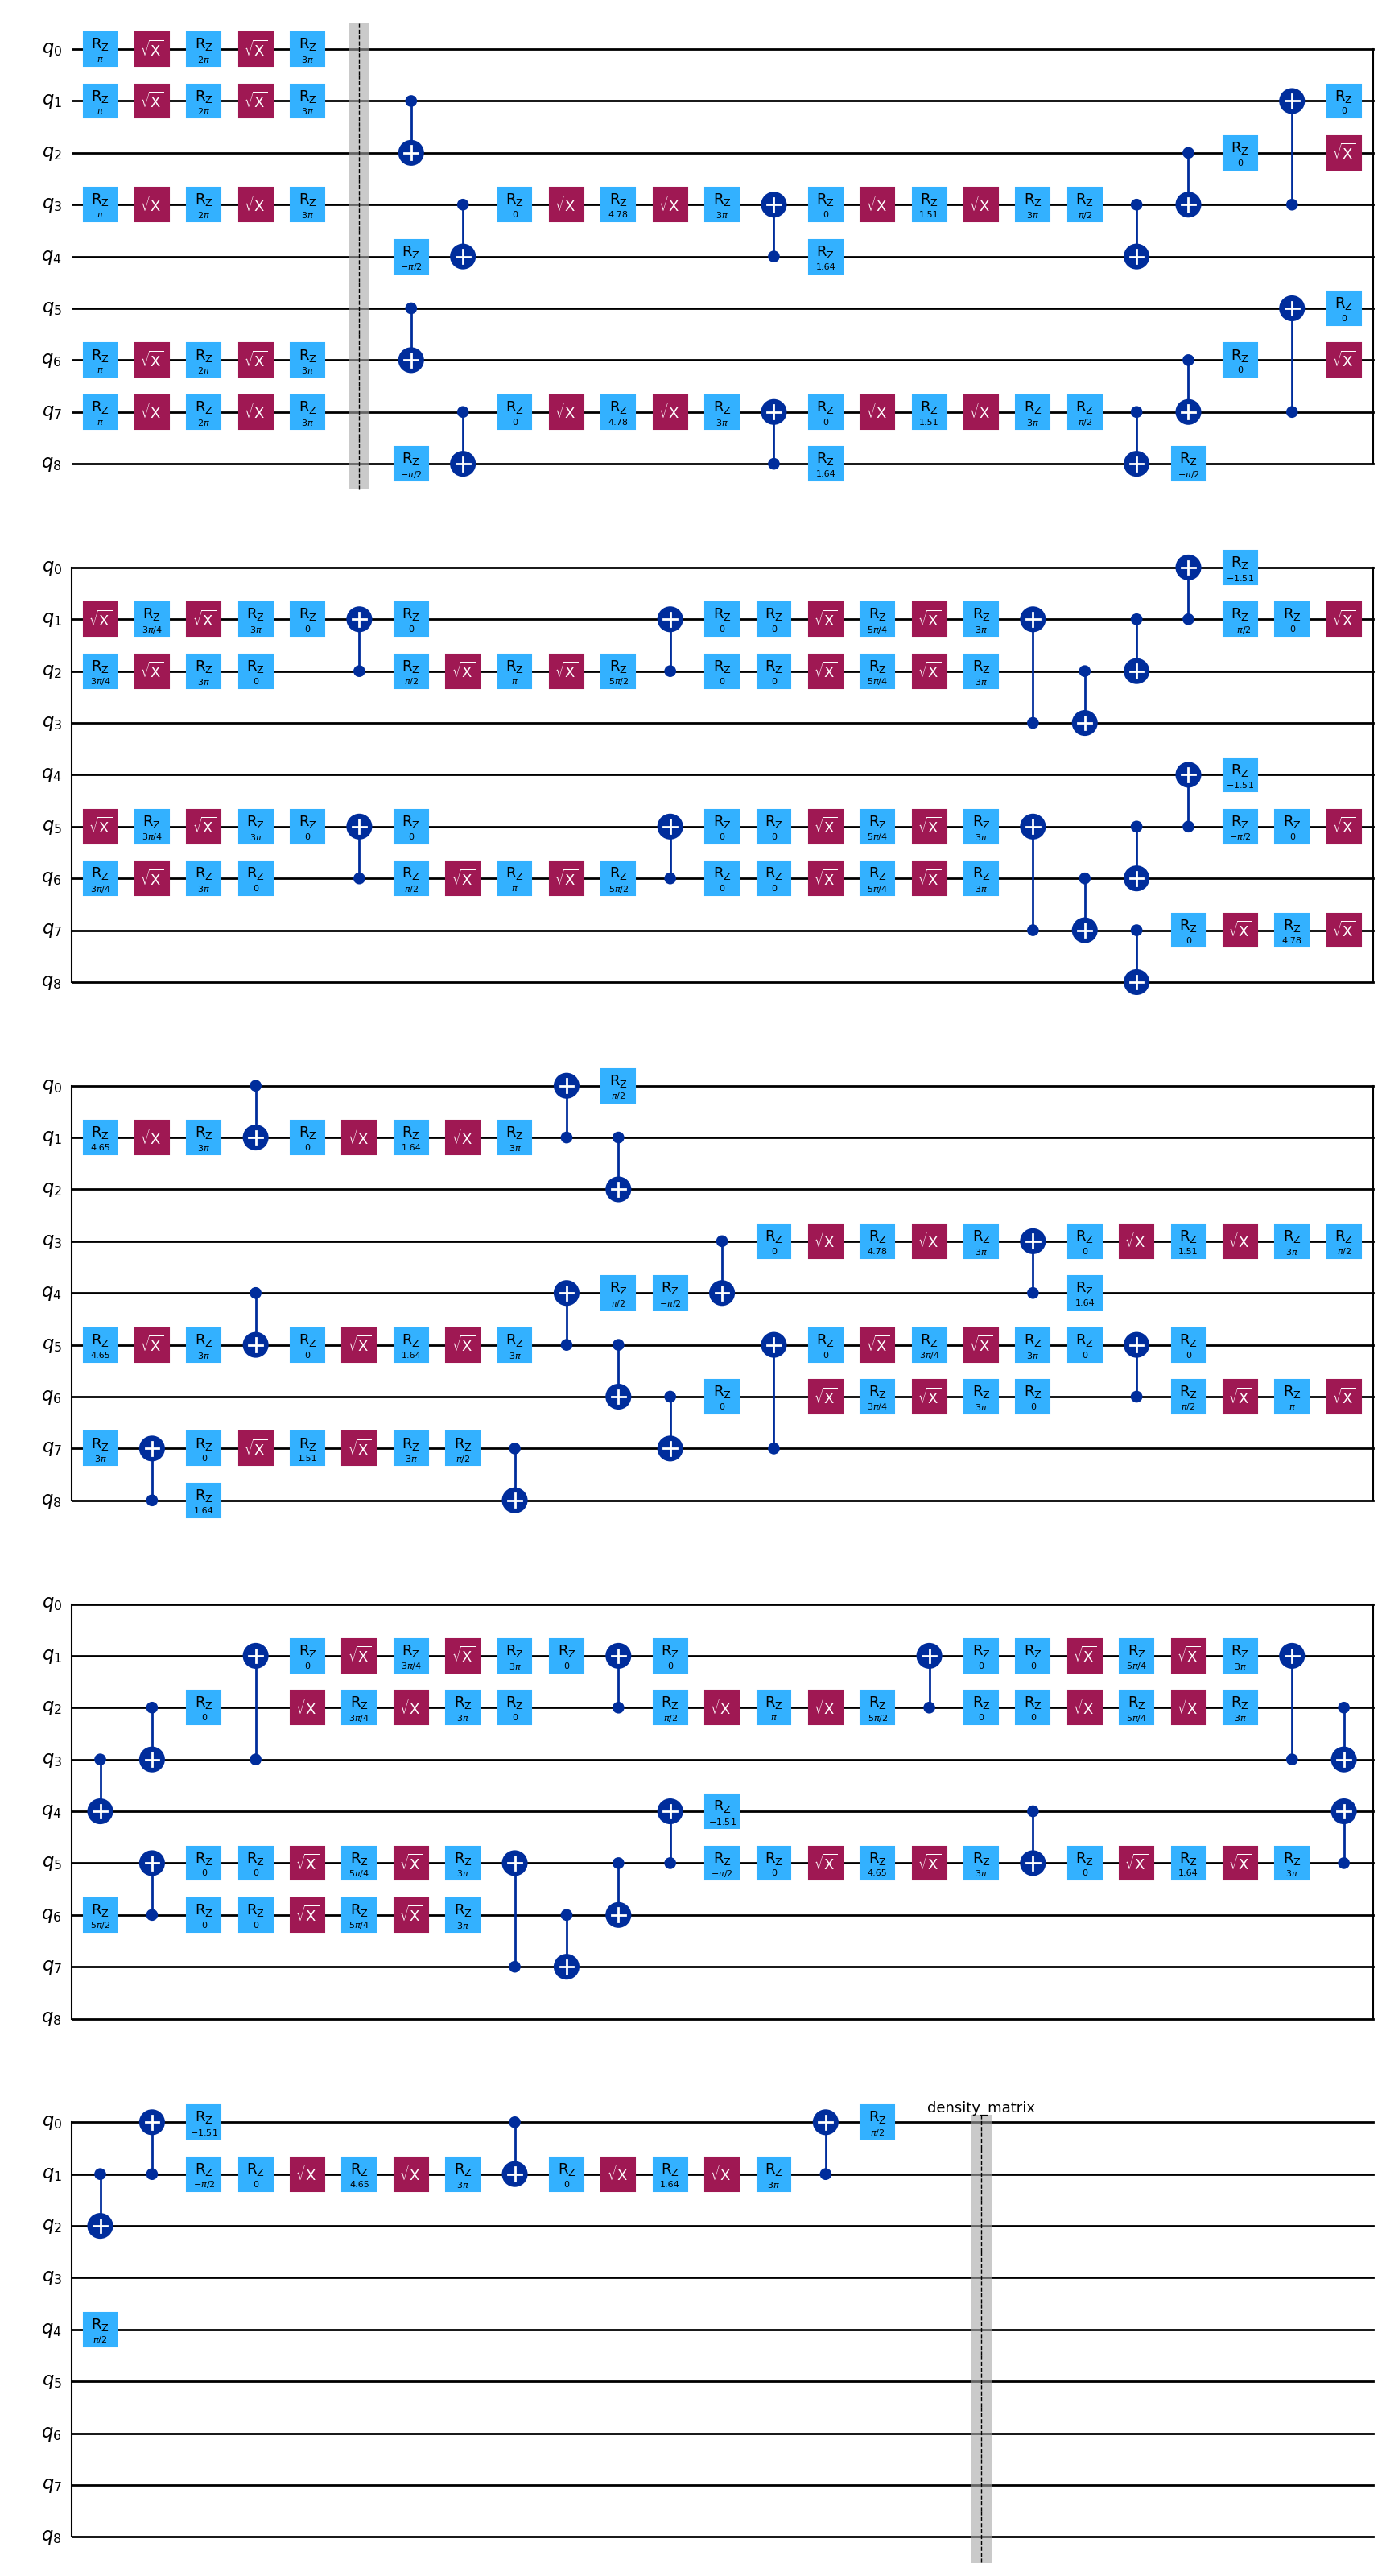

In [ ]:
qc = QuantumCircuit(num_qubits)

# Prepare initial state
append_initial_state(qc=qc, 
                     state_initial_str=state_initial_str,
                     add_barrier=True)
append_block_trotter_proposed(qc=qc, 
                              dt=dt / 2, 
                              num_steps=2 * 2)

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.assign_parameters({dt: time_evolution / num_steps})
# qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=3, basis_gates=["sx", "cx", "rz"])
qc_t3 = transpile(qc, optimization_level=0, basis_gates=["sx", "cx", "rz"])
qc_t3.save_density_matrix()
qc_t3.draw("mpl")

In [12]:
from osp_solutions.circuits_util import gate_Heff
qc = QuantumCircuit(2)

# Prepare initial state

qc.compose(gate_Heff(dt=dt,
                     to_instruction=False,),
           qubits=[0,1],
           inplace=True,)
qc.draw("mpl")

ImportError: cannot import name 'gate_Heff' from 'osp_solutions.circuits' (/Users/BOBO1997/Documents/projects/osp_solutions/.venv/lib/python3.11/site-packages/osp_solutions/circuits.py)